# Assignment 4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import json
import spacy
from spacy import displacy
from sklearn.metrics import confusion_matrix
from sklearn_crfsuite import metrics
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report
from spacy.tokens import Doc
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("ner.csv")
df.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [4]:
df = df.drop(["Tag"], axis=1)

In [5]:
df.head(5)

,Sentence #,Sentence,POS
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D..."


In [6]:
df['Sentence #'].value_counts()

Sentence #
Sentence: 1        1
Sentence: 31978    1
Sentence: 31969    1
Sentence: 31970    1
Sentence: 31971    1
                  ..
Sentence: 15989    1
Sentence: 15990    1
Sentence: 15991    1
Sentence: 15992    1
Sentence: 47959    1
Name: count, Length: 47959, dtype: int64

In [7]:
sample_df = df.head(300).copy()

## SpaCy en_core_web_sm

In [9]:
# Function to get Doccano-style entities
nlp = spacy.load("en_core_web_sm")

def get_spacy_entities(text):
    doc = nlp(text)
    return [[ent.start_char, ent.end_char, ent.label_] for ent in doc.ents]

# Create Doccano-ready columns
sample_df["text"] = sample_df["Sentence"]
sample_df["label"] = sample_df["Sentence"].apply(get_spacy_entities)

# Only keep relevant columns
spacy_df = sample_df[["text", "label"]]

In [10]:
def spacy_export(df, output_path="spacy_ner.jsonl"):
    with open(output_path, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            text = row["text"]
            labels = row["label"] if isinstance(row["label"], list) else []
            json.dump({"text": text, "label": labels}, f)
            f.write("\n")

# Usage
spacy_export(spacy_df)


## First Model with Annotated Data

In [12]:
def jsonl_to_conll_variable(input_file):
    """
    Convert a JSONL file to a CONLL formatted string variable for NER training.

    Each JSON object in the JSONL file should have:
      - "text": The raw text.
      - "label": A list of entity annotations in the format [start, end, label].

    Returns:
      A string containing the CONLL formatted data.
    """
    # Load spaCy model for tokenization and sentence segmentation.
    nlp = spacy.load("en_core_web_sm")

    conll_lines = []

    with open(input_file, 'r', encoding='utf-8') as infile:
        for line in infile:
            line = line.strip()
            if not line:
                continue
            data = json.loads(line)
            text = data.get("text", "")
            # Expecting "label" to be a list of lists: [start, end, entity_label]
            labels = data.get("label", [])

            # Process the text using spaCy.
            doc = nlp(text)

            # Process each sentence in the document.
            for sent in doc.sents:
                for token in sent:
                    token_tag = "O"
                    # Check if the token's span is within any annotated entity span.
                    for start, end, ent_label in labels:
                        if token.idx >= start and (token.idx + len(token)) <= end:
                            # Mark token as beginning (B-) or inside (I-) of an entity.
                            if token.idx == start:
                                token_tag = f"B-{ent_label}"
                            else:
                                token_tag = f"I-{ent_label}"
                            break
                    conll_lines.append(f"{token.text} {token_tag}")
                # Append a blank line to separate sentences.
                conll_lines.append("")

    # Join all lines into a single string.
    conll_text = "\n".join(conll_lines)
    return conll_text

### Convert Doccano Data from JSONL to CONLL

In [14]:
# from JSONL again to CONLL , ready for training
input_file = "train_data.jsonl"  # Replace with the path to your JSONL file.
conll_output = jsonl_to_conll_variable(input_file)
print(conll_output)  # You can now use conll_output for NER training.

Thousands B-CARDINAL
of O
demonstrators O
have O
marched O
through O
London B-GPE
to O
protest O
the O
war O
in O
Iraq B-GPE
and O
demand O
the O
withdrawal O
of O
British B-NORP
troops O
from O
that O
country O
. O

Families O
of O
soldiers O
killed O
in O
the O
conflict O
joined O
the O
protesters O
who O
carried O
banners O
with O
such O
slogans O
as O
" O
Bush B-PERSON
Number O
One O
Terrorist O
" O
and O
" O
Stop O
the O
Bombings O
. O
" O

They O
marched O
from O
the B-ORG
Houses I-ORG
of I-ORG
Parliament I-ORG
to O
a O
rally O
in O
Hyde B-GPE
Park I-GPE
. O

Police O
put O
the O
number O
of O
marchers O
at O
10,000 B-CARDINAL
while O
organizers O
claimed O
it O
was O
1,00,000 B-CARDINAL
. O

The O
protest O
comes O
on O
the O
eve O
of O
the O
annual O
conference O
of O
Britain B-GPE
's O
ruling O
Labor B-ORG
Party I-ORG
in O
the O
southern O
English B-NORP
seaside O
resort O
of O
Brighton B-GPE
. O

The O
party O
is O
divided O
over O
Britain B-GPE
's O
participation O
in O
the 

In [15]:
with open('conll_output.txt', 'w', encoding='utf-8') as f:
    f.write(conll_output)

In [16]:
def read_conll(filename):
    """Read CoNLL-formatted data from a file."""
    sentences = []
    with open(filename, encoding="utf-8") as f:
        sentence = []
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.split()
                # Use the first column as the word and the last column as the label.
                word = parts[0]
                label = parts[-1]
                sentence.append((word, label))
        if sentence:
            sentences.append(sentence)
    return sentences

def word2features(sent, i):
    """Extract simple features for the word at position i in the sentence."""
    word = sent[i][0]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    # Add previous word's feature if available
    if i > 0:
        features['prev.word.lower()'] = sent[i-1][0].lower()
    else:
        features['BOS'] = True  # Beginning of Sentence
    # Add next word's feature if available
    if i < len(sent) - 1:
        features['next.word.lower()'] = sent[i+1][0].lower()
    else:
        features['EOS'] = True  # End of Sentence
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, label in sent]

### Model Training

In [18]:
filename = "conll_output.txt"
sentences = read_conll(filename)
print(f"Read {len(sentences)} sentences from {filename}.")

train_sents, test_sents = train_test_split(sentences, test_size=0.2, random_state=42)
print(f"Number of training sentences: {len(train_sents)}")
print(f"Number of test sentences: {len(test_sents)}")

# Prepare the features and labels for both sets
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

# Initialize and train the CRF model
crf = CRF(algorithm='lbfgs', max_iterations=50)
crf.fit(X_train, y_train)

# Predict on the training set
y_pred = crf.predict(X_train)

Read 301 sentences from conll_output.txt.
Number of training sentences: 240
Number of test sentences: 61


### Training Accuracy

In [20]:
# Compute and print training accuracy
accuracy = metrics.flat_accuracy_score(y_train, y_pred)
print("Training Accuracy: {:.4f}".format(accuracy))

# Optionally, print a detailed classification report
report = metrics.flat_classification_report(y_train, y_pred)
print(report)

Training Accuracy: 0.9744
              precision    recall  f1-score   support

  B-CARDINAL       0.94      0.67      0.78        97
       B-GPE       0.96      0.96      0.96       198
      B-NORP       0.97      0.90      0.93        98
       B-ORG       0.88      0.70      0.78       105
    B-PERSON       0.97      0.85      0.91        73
  I-CARDINAL       1.00      0.50      0.67        16
       I-GPE       1.00      0.78      0.88        37
      I-NORP       1.00      0.33      0.50         3
       I-ORG       0.91      0.93      0.92       115
    I-PERSON       0.94      1.00      0.97        60
           O       0.98      1.00      0.99      4510

    accuracy                           0.97      5312
   macro avg       0.96      0.78      0.84      5312
weighted avg       0.97      0.97      0.97      5312



### Testing Accuracy

In [22]:
# Predict on the training set
y_pred = crf.predict(X_test)
# Compute and print training accuracy
accuracy = metrics.flat_accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.4f}".format(accuracy))

# Optionally, print a detailed classification report
report = metrics.flat_classification_report(y_test, y_pred)
print(report)

Test Accuracy: 0.9250
              precision    recall  f1-score   support

  B-CARDINAL       0.80      0.55      0.65        22
       B-GPE       0.89      0.71      0.79        59
      B-NORP       0.91      0.81      0.86        26
       B-ORG       0.72      0.41      0.52        32
    B-PERSON       0.68      0.59      0.63        22
  I-CARDINAL       0.00      0.00      0.00         2
       I-GPE       0.80      0.25      0.38        16
      I-NORP       0.00      0.00      0.00         2
       I-ORG       0.68      0.64      0.66        44
    I-PERSON       0.68      0.88      0.77        17
           O       0.95      0.99      0.97      1171

    accuracy                           0.92      1413
   macro avg       0.65      0.53      0.57      1413
weighted avg       0.92      0.92      0.92      1413



### Classification Report

In [24]:
def aggregate_label(label):
    """
    Remove the B- or I- prefix from a label.
    Returns the base entity (e.g., "B-corporation" or "I-corporation" becomes "corporation").
    The "O" label remains unchanged.
    """
    if label == "O":
        return label
    if "-" in label:
        return label.split("-", 1)[1]
    return label

# Build aggregated lists by iterating pairwise over each sentence.
y_true_agg = []
y_pred_agg = []
for true_sent, pred_sent in zip(y_test, y_pred):
    for true_label, pred_label in zip(true_sent, pred_sent):
        # Only include tokens where the true label is not "O"
        if true_label != "O":
            y_true_agg.append(aggregate_label(true_label))
            y_pred_agg.append(aggregate_label(pred_label))

# Determine the list of non-"O" labels from the aggregated true labels.
non_o_labels = sorted(set(y_true_agg))

# Now generate the classification report using only the non-"O" labels.
report = classification_report(y_true_agg, y_pred_agg, labels=non_o_labels, digits=4)
print("Aggregated Classification Report (without O tokens):")
print(report)


Aggregated Classification Report (without O tokens):
              precision    recall  f1-score   support

    CARDINAL     1.0000    0.5417    0.7027        24
         GPE     0.9412    0.6400    0.7619        75
        NORP     0.9130    0.7500    0.8235        28
         ORG     0.7500    0.5526    0.6364        76
      PERSON     0.8108    0.7692    0.7895        39

   micro avg     0.8556    0.6364    0.7299       242
   macro avg     0.8830    0.6507    0.7428       242
weighted avg     0.8627    0.6364    0.7282       242



### Aggregated Confusion Matrix

In [26]:
# Flatten and aggregate the labels.
y_true_flat = [aggregate_label(label) for sent in y_test for label in sent]
y_pred_flat = [aggregate_label(label) for sent in y_pred for label in sent]

# save Model 1’s truth & preds
y_true_flat_model1 = y_true_flat.copy()
y_pred_flat_model1 = y_pred_flat.copy()

# Determine the sorted set of aggregated labels.
labels = sorted(list(set(y_true_flat + y_pred_flat)))

# Compute the confusion matrix.
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

print("\nAggregated Confusion Matrix:")
df_cm


Aggregated Confusion Matrix:


,CARDINAL,GPE,NORP,O,ORG,PERSON
CARDINAL,13,0,0,10,0,1
GPE,0,48,1,15,9,2
NORP,0,0,21,3,3,1
O,4,1,0,1159,3,4
ORG,0,2,1,28,42,3
PERSON,0,1,0,6,2,30


### Export to Annotate Again

In [28]:
doccano_data = []

# Function to convert to Doccano format
def convert_to_doccano(sents, labels):
    data = []
    for sent, true_labels in zip(sents, labels):
        tokens = [token for token, label in sent]
        sentence_text = " ".join(tokens)

        offset = 0
        entities = []

        for token, label in zip(tokens, true_labels):
            start_pos = offset
            end_pos = start_pos + len(token)

            if label != "O":  # Only keep entities, skip non-entity tokens
                entity_label = label.split("-")[-1]  # Handle BIO format
                entities.append([start_pos, end_pos, entity_label])

            offset = end_pos + 1  # +1 for space

        data.append({
            "text": sentence_text,
            "label": entities
        })
    return data


In [29]:
sample_df_2 = df.sample(n=300, random_state=42)
sample_df_2["text"] = sample_df_2["Sentence"]
sample_df_2["label"] = sample_df_2["Sentence"].apply(get_spacy_entities)

# Only keep relevant columns
doccano_df_2 = sample_df_2[["text", "label"]]

In [30]:
doccano_df_2.head()

,text,label
13389,"In Tehran , the chief of Iran 's Revolutionary...","[[3, 9, GPE], [25, 29, GPE], [33, 53, ORG], [6..."
3035,"Even though both sites are now functioning , T...","[[45, 52, PERSON]]"
6013,Suspected U.S. drones have carried out at leas...,"[[0, 9, GPE], [10, 14, GPE], [39, 50, CARDINAL..."
34939,President Barack Obama has reaffirmed his beli...,"[[10, 22, PERSON], [110, 127, CARDINAL], [161,..."
9604,They all decided that one person should get of...,"[[22, 25, CARDINAL]]"


In [31]:
doccano_df_2.to_json('annotations_2.jsonl', orient='records', lines=True)

## Second Model with Annotated Data

### Convert Doccano Data from JSONL to CONLL

In [34]:
# from JSONL again to CONLL , ready for training
input_file = "train_data_2.jsonl"
conll_output = jsonl_to_conll_variable(input_file)
print(conll_output)  # You can now use conll_output for NER training.

Thousands B-CARDINAL
of O
demonstrators O
have O
marched O
through O
London B-GPE
to O
protest O
the O
war O
in O
Iraq B-GPE
and O
demand O
the O
withdrawal O
of O
British B-NORP
troops O
from O
that O
country O
. O

Families O
of O
soldiers O
killed O
in O
the O
conflict O
joined O
the O
protesters O
who O
carried O
banners O
with O
such O
slogans O
as O
" O
Bush B-PERSON
Number O
One O
Terrorist O
" O
and O
" O
Stop O
the O
Bombings O
. O
" O

They O
marched O
from O
the B-ORG
Houses I-ORG
of I-ORG
Parliament I-ORG
to O
a O
rally O
in O
Hyde B-GPE
Park I-GPE
. O

Police O
put O
the O
number O
of O
marchers O
at O
10,000 B-CARDINAL
while O
organizers O
claimed O
it O
was O
1,00,000 B-CARDINAL
. O

The O
protest O
comes O
on O
the O
eve O
of O
the O
annual O
conference O
of O
Britain B-GPE
's O
ruling O
Labor B-ORG
Party I-ORG
in O
the O
southern O
English B-NORP
seaside O
resort O
of O
Brighton B-GPE
. O

The O
party O
is O
divided O
over O
Britain B-GPE
's O
participation O
in O
the 

In [35]:
with open('conll_output_2.txt', 'w', encoding='utf-8') as f:
    f.write(conll_output)

### Training the Model

In [37]:
filename = "conll_output_2.txt" # Replace with the path to your JSONL file.
sentences = read_conll(filename)
print(f"Read {len(sentences)} sentences from {filename}.")

train_sents, test_sents = train_test_split(sentences, test_size=0.2, random_state=42)
print(f"Number of training sentences: {len(train_sents)}")
print(f"Number of test sentences: {len(test_sents)}")

# Prepare the features and labels for both sets
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

# Initialize and train the CRF model
crf = CRF(algorithm='lbfgs', max_iterations=50)
crf.fit(X_train, y_train)

# Predict on the training set
y_pred = crf.predict(X_train)

Read 601 sentences from conll_output_2.txt.
Number of training sentences: 480
Number of test sentences: 121


### Training Accuracy

In [39]:
# Compute and print training accuracy
accuracy = metrics.flat_accuracy_score(y_train, y_pred)
print("Training Accuracy: {:.4f}".format(accuracy))

# Optionally, print a detailed classification report
report = metrics.flat_classification_report(y_train, y_pred)
print(report)

Training Accuracy: 0.9771
              precision    recall  f1-score   support

  B-CARDINAL       0.89      0.71      0.79       160
       B-GPE       0.93      0.96      0.95       398
      B-NORP       0.95      0.93      0.94       196
       B-ORG       0.92      0.82      0.87       195
    B-PERSON       0.92      0.81      0.86       175
  I-CARDINAL       0.94      0.48      0.64        31
       I-GPE       0.94      0.81      0.87        98
      I-NORP       1.00      0.69      0.82        13
       I-ORG       0.93      0.94      0.94       226
    I-PERSON       0.95      0.94      0.95       181
           O       0.98      1.00      0.99      9047

    accuracy                           0.98     10720
   macro avg       0.94      0.83      0.87     10720
weighted avg       0.98      0.98      0.98     10720



### Testing Accuracy

In [41]:
# Predict on the training set
y_pred = crf.predict(X_test)
# Compute and print training accuracy
accuracy = metrics.flat_accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.4f}".format(accuracy))

# Optionally, print a detailed classification report
report = metrics.flat_classification_report(y_test, y_pred)
print(report)

Test Accuracy: 0.9344
              precision    recall  f1-score   support

  B-CARDINAL       0.85      0.64      0.73        45
       B-GPE       0.86      0.80      0.83       121
      B-NORP       0.88      0.76      0.81        37
       B-ORG       0.71      0.51      0.59        53
    B-PERSON       0.69      0.54      0.61        37
  I-CARDINAL       1.00      0.36      0.53        11
       I-GPE       1.00      0.58      0.73        38
      I-NORP       0.00      0.00      0.00         1
       I-ORG       0.63      0.90      0.74        62
    I-PERSON       0.74      0.71      0.72        35
           O       0.96      0.98      0.97      2121

    accuracy                           0.93      2561
   macro avg       0.76      0.62      0.66      2561
weighted avg       0.93      0.93      0.93      2561



### Aggregated Classification Report

In [43]:
# Build aggregated lists by iterating pairwise over each sentence.
y_true_agg = []
y_pred_agg = []
for true_sent, pred_sent in zip(y_test, y_pred):
    for true_label, pred_label in zip(true_sent, pred_sent):
        # Only include tokens where the true label is not "O"
        if true_label != "O":
            y_true_agg.append(aggregate_label(true_label))
            y_pred_agg.append(aggregate_label(pred_label))

# Determine the list of non-"O" labels from the aggregated true labels.
non_o_labels = sorted(set(y_true_agg))

# Now generate the classification report using only the non-"O" labels.
report = classification_report(y_true_agg, y_pred_agg, labels=non_o_labels, digits=4)
print("Aggregated Classification Report (without O tokens):")
print(report)

Aggregated Classification Report (without O tokens):
              precision    recall  f1-score   support

    CARDINAL     1.0000    0.5893    0.7416        56
         GPE     0.9618    0.7925    0.8690       159
        NORP     0.8750    0.7368    0.8000        38
         ORG     0.8396    0.7739    0.8054       115
      PERSON     0.8947    0.7083    0.7907        72

   micro avg     0.9109    0.7432    0.8185       440
   macro avg     0.9142    0.7202    0.8013       440
weighted avg     0.9163    0.7432    0.8174       440



### Aggregated Confusion Matrix

In [45]:
# Flatten and aggregate the labels.
y_true_flat = [aggregate_label(label) for sent in y_test for label in sent]
y_pred_flat = [aggregate_label(label) for sent in y_pred for label in sent]

# save Model 1’s truth & preds
y_true_flat_model2 = y_true_flat.copy()
y_pred_flat_model2 = y_pred_flat.copy()

# Determine the sorted set of aggregated labels.
labels = sorted(list(set(y_true_flat + y_pred_flat)))

# Compute the confusion matrix.
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

print("\nAggregated Confusion Matrix:")
df_cm


Aggregated Confusion Matrix:


,CARDINAL,GPE,NORP,O,ORG,PERSON
CARDINAL,33,0,0,23,0,0
GPE,0,126,1,29,3,0
NORP,0,0,28,5,4,1
O,5,4,0,2085,21,6
ORG,0,3,1,17,89,5
PERSON,0,2,2,7,10,51


### Comparison of Model Performance

In [47]:
def train_evaluate_crf(sentences, sizes, test_size=0.2, random_state=42):
    f1_scores = []

    # Fix the test set once
    train_full, test_sents = train_test_split(sentences, test_size=test_size, random_state=random_state)
    X_test = [sent2features(s) for s in test_sents]
    y_test = [sent2labels(s) for s in test_sents]

    for size in sizes:
        train_subset = train_full[:size]
        X_train = [sent2features(s) for s in train_subset]
        y_train = [sent2labels(s) for s in train_subset]

        crf = CRF(algorithm='lbfgs', max_iterations=50)
        crf.fit(X_train, y_train)

        y_pred = crf.predict(X_test)
        f1 = metrics.flat_f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)
        print(f"Trained on {size} samples — F1: {f1:.4f}")

    return sizes, f1_scores


In [48]:
sizes = [100, 200, 300, 400, 500, 600]
filename = "conll_output_2.txt"
sentences = read_conll(filename)

x_vals, f1_vals = train_evaluate_crf(sentences, sizes)

Trained on 100 samples — F1: 0.8636
Trained on 200 samples — F1: 0.8988
Trained on 300 samples — F1: 0.9179
Trained on 400 samples — F1: 0.9206
Trained on 500 samples — F1: 0.9315
Trained on 600 samples — F1: 0.9315


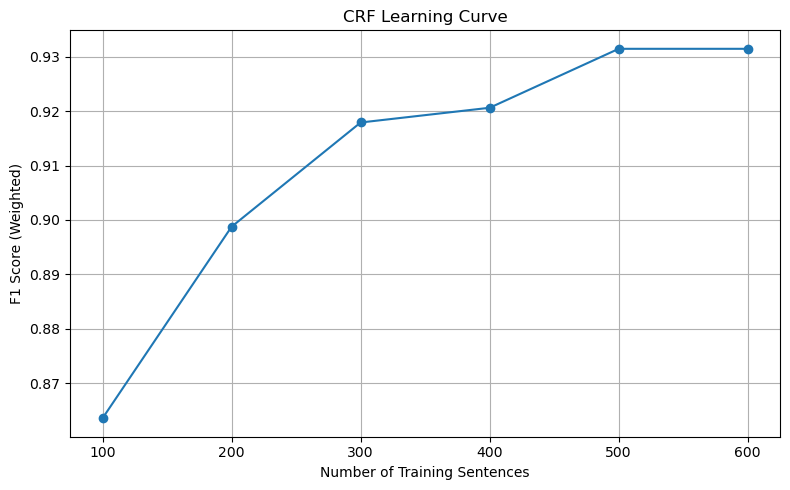

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(x_vals, f1_vals, marker='o', linestyle='-')
plt.title("CRF Learning Curve")
plt.xlabel("Number of Training Sentences")
plt.ylabel("F1 Score (Weighted)")
plt.grid(True)
plt.tight_layout()
plt.show()

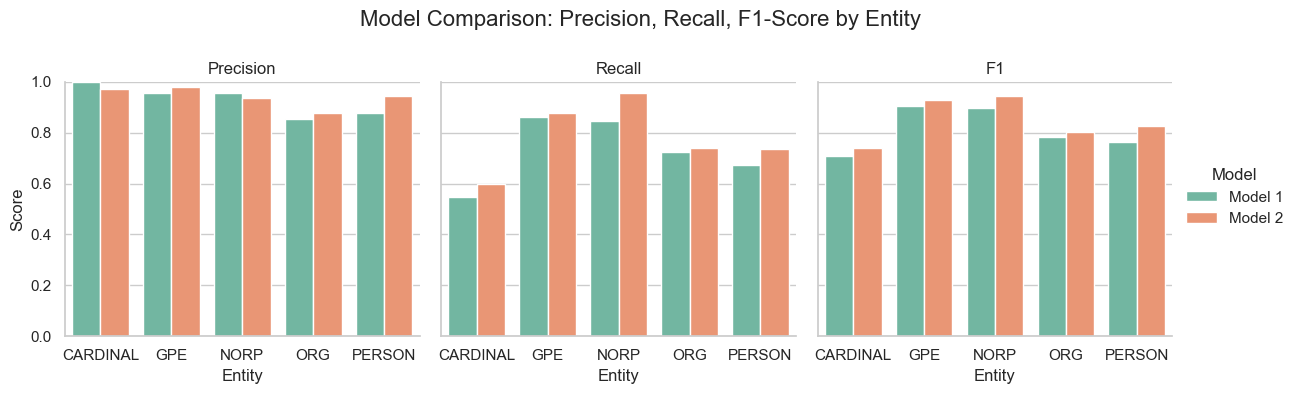

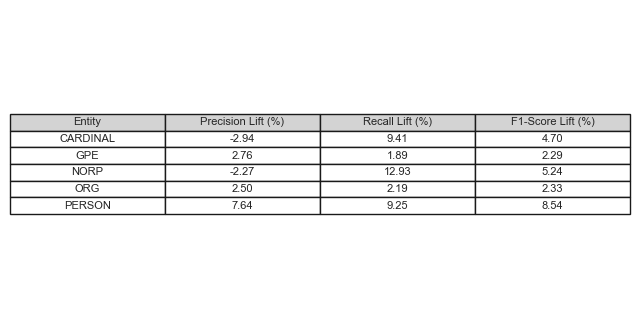

In [50]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Metrics for models
model1_metrics = {
    'CARDINAL': {'precision': 1.0000, 'recall': 0.5484, 'f1': 0.7083},
    'GPE': {'precision': 0.9545, 'recall': 0.8630, 'f1': 0.9065},
    'NORP': {'precision': 0.9565, 'recall': 0.8462, 'f1': 0.8980},
    'ORG': {'precision': 0.8548, 'recall': 0.7260, 'f1': 0.7852},
    'PERSON': {'precision': 0.8788, 'recall': 0.6744, 'f1': 0.7632},
}

model2_metrics = {
    'CARDINAL': {'precision': 0.9706, 'recall': 0.6000, 'f1': 0.7416},
    'GPE': {'precision': 0.9808, 'recall': 0.8793, 'f1': 0.9273},
    'NORP': {'precision': 0.9348, 'recall': 0.9556, 'f1': 0.9451},
    'ORG': {'precision': 0.8762, 'recall': 0.7419, 'f1': 0.8035},
    'PERSON': {'precision': 0.9459, 'recall': 0.7368, 'f1': 0.8284},
}

# Prepare DataFrame for plotting
metrics = ['precision', 'recall', 'f1']
rows = []
for label in model1_metrics:
    for metric in metrics:
        rows.append({'Label': label, 'Metric': metric.capitalize(), 'Model': 'Model 1', 'Score': model1_metrics[label][metric]})
        rows.append({'Label': label, 'Metric': metric.capitalize(), 'Model': 'Model 2', 'Score': model2_metrics[label][metric]})

df_long = pd.DataFrame(rows)

# Create plots
sns.set(style="whitegrid")
g = sns.catplot(data=df_long, kind="bar", x="Label", y="Score", hue="Model", col="Metric", palette="Set2", height=4, aspect=1)
g.set_titles("{col_name}")
g.set_axis_labels("Entity", "Score")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Model Comparison: Precision, Recall, F1-Score by Entity", fontsize=16)

# Calculate Lift in percentage
lift_data = []
for label in model1_metrics:
    precision_lift = ((model2_metrics[label]['precision'] - model1_metrics[label]['precision']) / model1_metrics[label]['precision']) * 100
    recall_lift = ((model2_metrics[label]['recall'] - model1_metrics[label]['recall']) / model1_metrics[label]['recall']) * 100
    f1_lift = ((model2_metrics[label]['f1'] - model1_metrics[label]['f1']) / model1_metrics[label]['f1']) * 100
    lift_data.append([label, f"{precision_lift:.2f}", f"{recall_lift:.2f}", f"{f1_lift:.2f}"])

# Lift table
lift_df = pd.DataFrame(lift_data, columns=['Entity', 'Precision Lift (%)', 'Recall Lift (%)', 'F1-Score Lift (%)'])

# Display Lift table below the plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
table = ax.table(cellText=lift_df.values, colLabels=lift_df.columns, loc='center', cellLoc='center', colColours=['lightgray']*4)
table.auto_set_font_size(False)
table.set_fontsize(8)
plt.show()


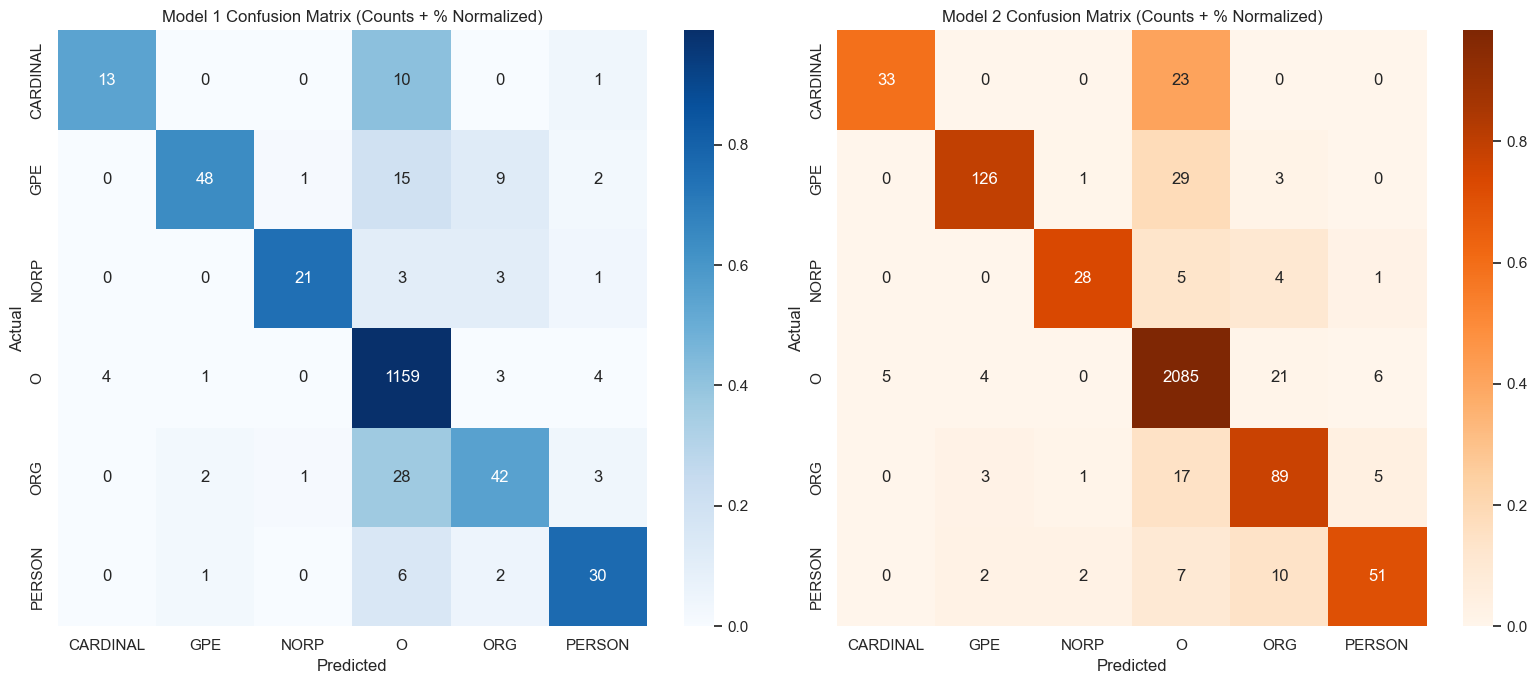

In [51]:
# Get confusion matrices
cm1 = confusion_matrix(y_true_flat_model1, y_pred_flat_model1, labels=labels)
cm2 = confusion_matrix(y_true_flat_model2, y_pred_flat_model2, labels=labels)

# Normalize by row (true labels)
cm1_norm = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
cm2_norm = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Model 1
sns.heatmap(cm1_norm, annot=cm1, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Model 1 Confusion Matrix (Counts + % Normalized)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Model 2
sns.heatmap(cm2_norm, annot=cm2, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Model 2 Confusion Matrix (Counts + % Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()
